# Objectives
1. Reformat the audio into the format that will be used in production - overlapping array segments of audio files.
1. Reformat the audio labels to match the desired production outcome - binary value indicating if the array segment contains a soccer juggle or not.

# Assumptions
* Data labels are within 5k indices of the true juggle signal peak
* The largest signal peak within 5k indices of the original data label is the true juggle signal

# Project Set Up

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import glob
import librosa
import os
import sys
import pickle

sys.path.append(os.getcwd())

import python_utils

print(sys.version)
print(pd.__version__)
print(np.__version__)
print(librosa.__version__)

3.9.21 (main, Dec  3 2024, 17:50:13) 
[GCC 13.3.0]
2.2.3
2.0.2
0.11.0


## Global Variables
- Length of ball signal is ~0.2 seconds.
- Use 0.3 seconds for window length to be safe.
- Window Length = 0.3 * Sample Rate
- Want Window Length to be even so 1/2 Window Length is still an integer. This will allow windows to overlap nicely

In [3]:
SAMPLE_RATE = 22050
FRAME_RATE = 30
LABEL_CORRECTION_SEARCH_WINDOW = 2500
LABEL_PATH = os.path.join("no_ground_hits", "labels_timestamp")
AUDIO_PATH = os.path.join("no_ground_hits", "audio_files")
PREPROCESSED_DATA_PATH = os.path.join("no_ground_hits", "preprocessed_data")
WINDOW_SIZE_SECONDS = 0.3

In [5]:
def round_up_to_even(number):
    """Rounds a number up to the next highest even number.

    Args:
        number: The number to round.

    Returns:
        The next highest even number.
    """
    if number % 2 == 0:
        return int(number)  # If already even, return as int
    else:
        return int(number) + 1


WINDOW_SIZE = round_up_to_even(WINDOW_SIZE_SECONDS * SAMPLE_RATE)

print(WINDOW_SIZE)

6616


## Set up Data Tracker Container

In [6]:
audio_filenames = glob.glob(os.path.join(AUDIO_PATH, "*.wav"))
base_names = [filename.split('/')[-1].replace('_audio.wav','') for filename in audio_filenames]
tracker = {
    base_names[i]: {
        "audio_filename": audio_filenames[i],
        "labels_filename": os.path.join(LABEL_PATH, base_names[i] + '_labels.txt'),
    }
    for i in range(len(base_names))
}


python_utils.custom_print(tracker)

{
  'PXL_20250222_012947893.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_1_labels.txt'
  }
  'PXL_20250223_164224211.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250223_164224211.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250223_164224211.TS_1_labels.txt'
  }
  'PXL_20250222_012947893.TS_2': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_2_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_2_labels.txt'
  }
  'PXL_20250222_013140200.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_013140200.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_013140200.TS_1_labels.txt'
  }
  'PXL_20250223_164321190.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250223_1643

# Load Data
* Labels (`labels_raw`) are (manually created) timestamps of approximately when a juggle was made
* Audio data (`audio_values`) are loaded as 1D numpy arrays
  * Each index is a sample of the audio data at the `SAMPLE_RATE`
  * Each value is the audio amplitude at that index

In [7]:
for base_name in tracker:
  tracker[base_name]["labels_raw"] = list()
  with open(tracker[base_name]["labels_filename"], 'r') as file:
      for line in file:
        tracker[base_name]["labels_raw"].append(line.strip())
  tracker[base_name]["audio_values"], _ = librosa.load(tracker[base_name]["audio_filename"], sr=SAMPLE_RATE)


python_utils.custom_print(tracker)

{
  'PXL_20250222_012947893.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_1_labels.txt'
    'labels_raw': ['00:00:01;20', '00:00:02;04', '00:00:02;21', '00:00:03;11', '00:00:03;29', '00:00:04;14', '00:00:05;02', '00:00:05;18', '00:00:06;12', '00:00:07;03', ...]
    'audio_values': array([0.        , 0.        , 0.        , ..., 0.00452999, 0.00253988,
       0.00217312], dtype=float32)
  }
  'PXL_20250223_164224211.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250223_164224211.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250223_164224211.TS_1_labels.txt'
    'labels_raw': ['00:00:01;29', '00:00:02;18', '00:00:03;04', '00:00:03;20', '00:00:04;05', '00:00:04;24', '00:00:05;13', '00:00:05;29', '00:00:06;14', '00:00:07;01', ...]
    'audio_values': array([ 0.        ,  0.        ,  0.        , ..., -0.00485

# Transform Data

## Transform Labels

### Reshape
* Labels are transformed into arrays that match the length of the audio data
  * Value is 1 where a soccer juggle occurs, 0 otherwise

In [8]:
def olive_timestamp_to_seconds(timestamp: str, frame_rate: int) -> float:
    """HH:MM:SS;FF -> seconds"""
    try:
        hours, minutes, seconds_frames = timestamp.split(':')
        seconds, frames = seconds_frames.split(';')
        return (
            float(hours) * 60 * 60  # Hours
            + float(minutes) * 60  # Minutes
            + float(seconds)  # Seconds
            + float(frames) / frame_rate  # Frames
        )
    except ValueError:
        return np.nan
    except IndexError:
        return np.nan


def transform_labels_timestamp_to_vector(labels_raw: list, sample_rate: int, frame_rate: int, data_size: int) -> list:
  labels = np.zeros(data_size)
  for raw_label in labels_raw:
    labels[
      int(
        olive_timestamp_to_seconds(
          timestamp=raw_label,
          frame_rate=frame_rate,
        ) * sample_rate
      )
    ] = 1
  return labels


# Test transform_audio
print(transform_labels_timestamp_to_vector(
      labels_raw=['00:00:01;00', '00:00:02;00', '00:00:05;00'],
      sample_rate=1,
      frame_rate=1,
      data_size=20,
))

[0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
for base_name in tracker:
  # Transform labels to match raw data array format
  tracker[base_name]["labels_full_array"] = transform_labels_timestamp_to_vector(
      labels_raw=tracker[base_name]["labels_raw"],
      sample_rate=SAMPLE_RATE,
      frame_rate=FRAME_RATE,
      data_size=len(tracker[base_name]["audio_values"])
  )
  # Check labels
  print(base_name)
  if np.any(np.isnan(tracker[base_name]["labels_full_array"])):
    print("IMPORT ERROR")
  else:
    print("PASS")


python_utils.custom_print(tracker)

PXL_20250222_012947893.TS_1
PASS
PXL_20250223_164224211.TS_1
PASS
PXL_20250222_012947893.TS_2
PASS
PXL_20250222_013140200.TS_1
PASS
PXL_20250223_164321190.TS_1
PASS
PXL_20250223_164250127.TS_1
PASS
{
  'PXL_20250222_012947893.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_1_labels.txt'
    'labels_raw': ['00:00:01;20', '00:00:02;04', '00:00:02;21', '00:00:03;11', '00:00:03;29', '00:00:04;14', '00:00:05;02', '00:00:05;18', '00:00:06;12', '00:00:07;03', ...]
    'audio_values': array([0.        , 0.        , 0.        , ..., 0.00452999, 0.00253988,
       0.00217312], dtype=float32)
    'labels_full_array': array([0., 0., 0., ..., 0., 0., 0.])
  }
  'PXL_20250223_164224211.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250223_164224211.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250223_164224211.TS_1_label

### Check Labels Match Data

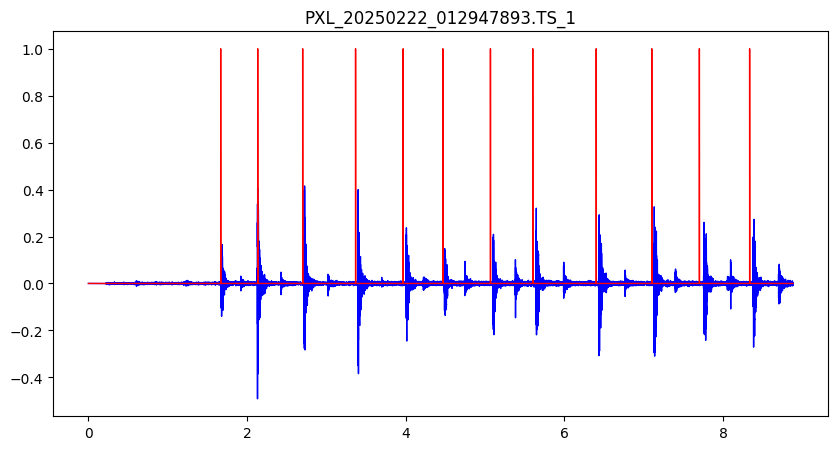

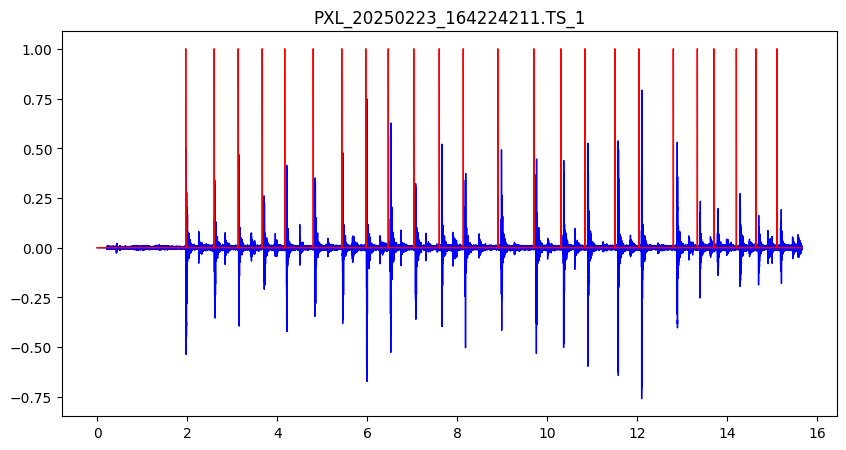

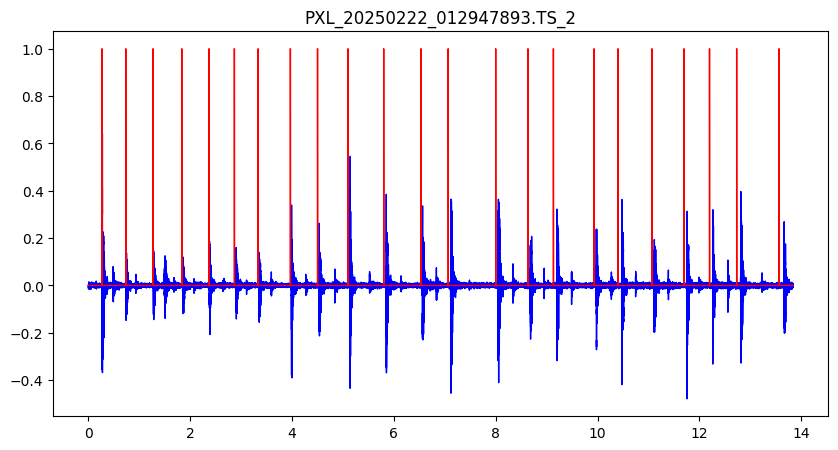

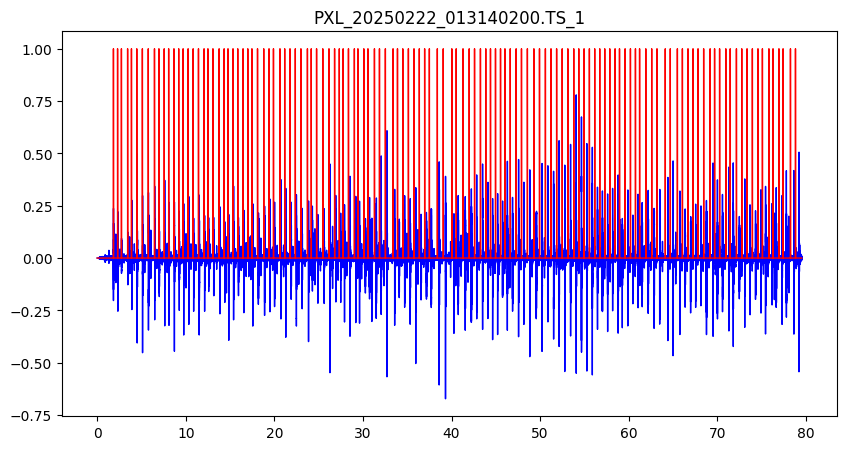

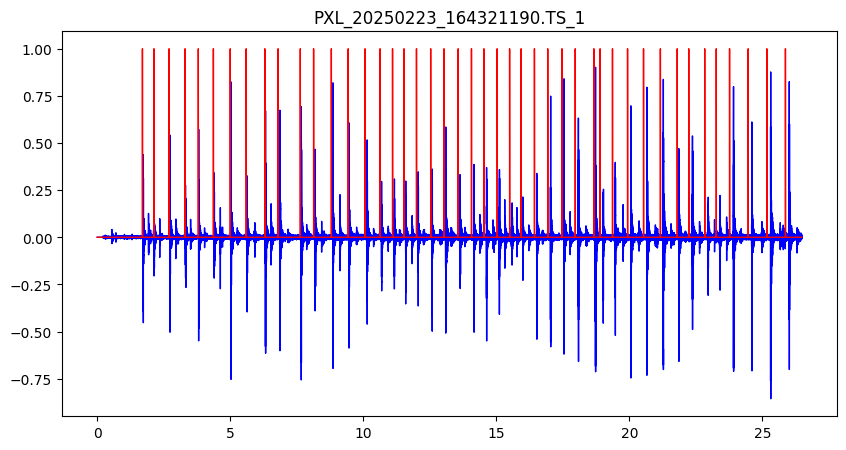

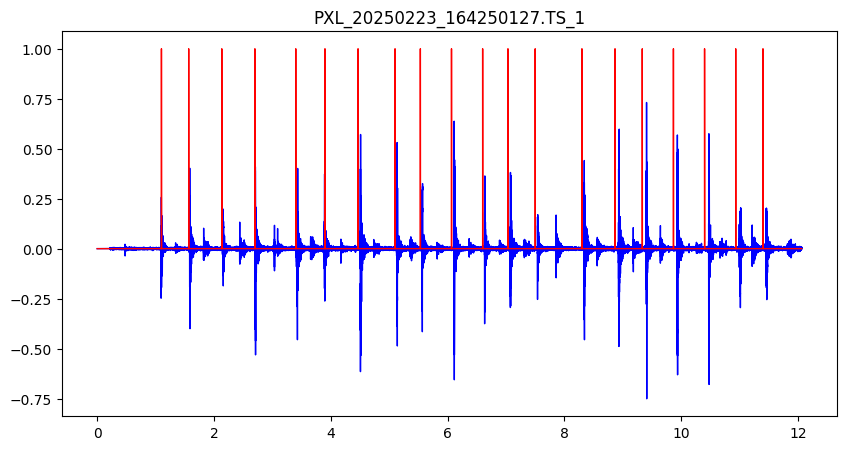

In [10]:

for base_name in tracker:
        x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
        pd.Series(tracker[base_name]["audio_values"],
                index=x_axis_labels).plot(figsize=(10, 5),
                        lw=1,
                        title=base_name,
                        color='blue')
        pd.Series(tracker[base_name]["labels_full_array"],
                index=x_axis_labels).plot(
                        lw=1,
                        color='r')
        # plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
        plt.show()

Notes:
* PXL_20250222_012947893.TS
    * At 10 seconds, the sound is the ball hitting the ground, not a juggle

### Correct Labels
- Data labels are originally collected by visually looking at a video and labeling the timestamp as close as possible to when a juggle occurs. 
- This process is not as accurate as desired.
- The following label correction process is intended to better match each data label to the true audio signal peak for each juggle:
    - Search near the manual label for a signal maximum.
    - Move the label to the nearby signal maximum.

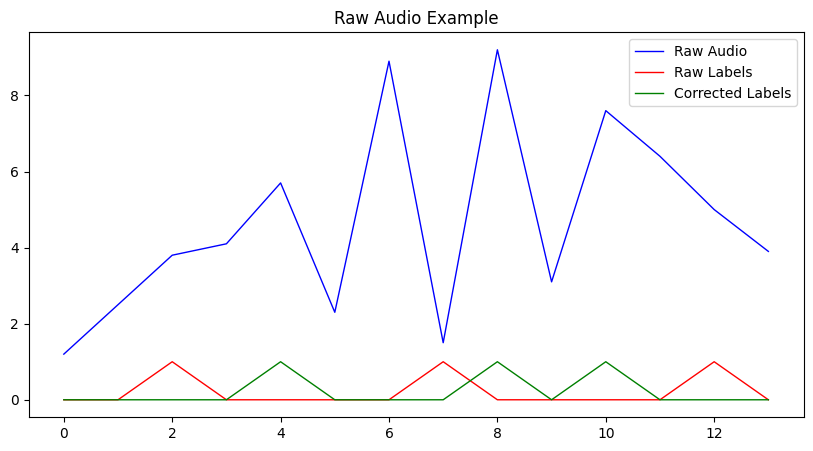

In [11]:
def correct_labels(boolean_array, real_array, search_step):
    """
    Corrects labels based on maximum values within a search window.

    Args:
        boolean_array (np.ndarray): Boolean array (1 or 0).
        real_array (np.ndarray): Real-valued array.
        search_step (int): Search window size.

    Returns:
        np.ndarray: Corrected labels array.
    """
    if len(boolean_array) != len(real_array):
        raise ValueError("Boolean and real arrays must have the same length.")
    ones_indices = np.where(boolean_array == 1)[0]
    # Check minimum distance between 1s
    for i in range(len(ones_indices)):
        for j in range(i + 1, len(ones_indices)):
            if abs(ones_indices[i] - ones_indices[j]) < search_step:
                raise ValueError("1s are too close together.")
    labels_corrected = np.zeros_like(boolean_array)
    for index in ones_indices:
        start = max(0, index - search_step)
        end = min(len(real_array), index + search_step + 1)
        search_window = real_array[start:end]
        max_index_relative = np.argmax(search_window)
        max_index_absolute = start + max_index_relative
        labels_corrected[max_index_absolute] = 1
    return labels_corrected


# Test correct_labels
boolean_array = np.array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])
real_array = np.array([1.2, 2.5, 3.8, 4.1, 5.7, 2.3, 8.9, 1.5, 9.2, 3.1, 7.6, 6.4, 5.0, 3.9])
search_step = 2

corrected_labels = correct_labels(boolean_array, real_array, search_step)

pd.Series(real_array).plot(
    figsize=(10, 5),
    lw=1,
    title='Raw Audio Example',
    color='blue',
    label='Raw Audio',
)
pd.Series(boolean_array).plot(
    lw=1,
    color='red',
    label='Raw Labels',
)
pd.Series(corrected_labels).plot(
    lw=1,
    color='green',
    label='Corrected Labels',
)
plt.legend()
plt.show()

In [12]:
for base_name in tracker:
  # Correct labels - ensure the labels are located at the local maxima of the audio signal
  tracker[base_name]["labels_corrected"] = correct_labels(
      boolean_array=tracker[base_name]["labels_full_array"],
      real_array=tracker[base_name]["audio_values"],
      search_step=LABEL_CORRECTION_SEARCH_WINDOW,
  )

python_utils.custom_print(tracker)

{
  'PXL_20250222_012947893.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_1_labels.txt'
    'labels_raw': ['00:00:01;20', '00:00:02;04', '00:00:02;21', '00:00:03;11', '00:00:03;29', '00:00:04;14', '00:00:05;02', '00:00:05;18', '00:00:06;12', '00:00:07;03', ...]
    'audio_values': array([0.        , 0.        , 0.        , ..., 0.00452999, 0.00253988,
       0.00217312], dtype=float32)
    'labels_full_array': array([0., 0., 0., ..., 0., 0., 0.])
    'labels_corrected': array([0., 0., 0., ..., 0., 0., 0.])
  }
  'PXL_20250223_164224211.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250223_164224211.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250223_164224211.TS_1_labels.txt'
    'labels_raw': ['00:00:01;29', '00:00:02;18', '00:00:03;04', '00:00:03;20', '00:00:04;05', '00:00:04;24', '00:00:05;13', '00:00

### Check Label Correction

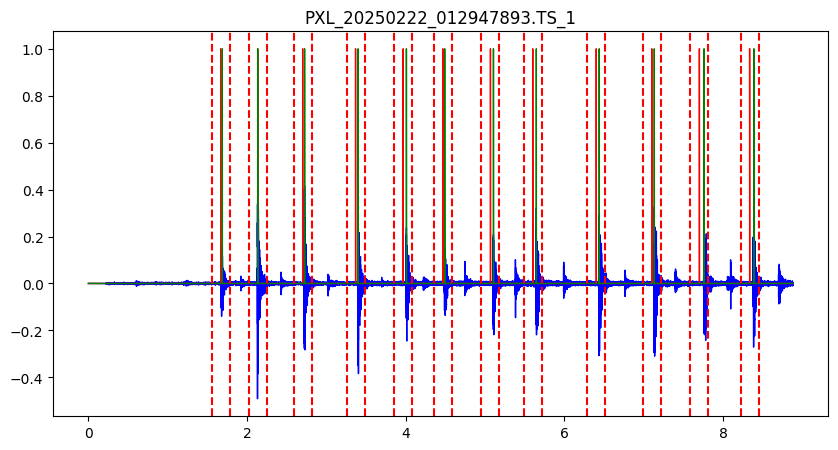

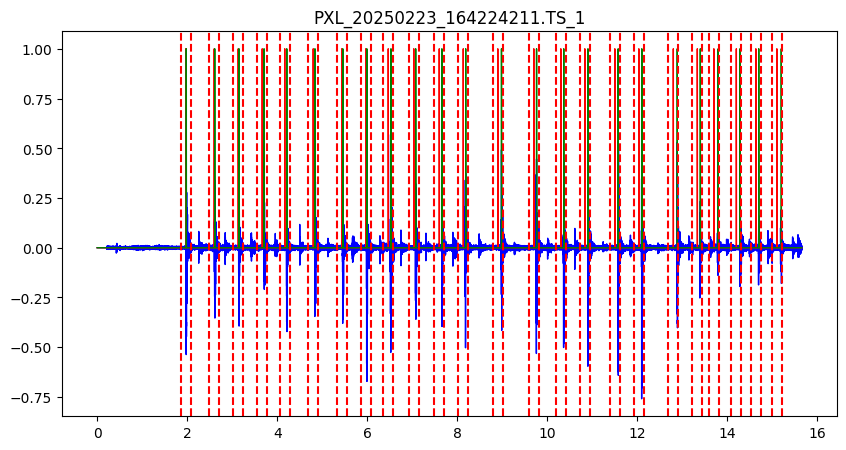

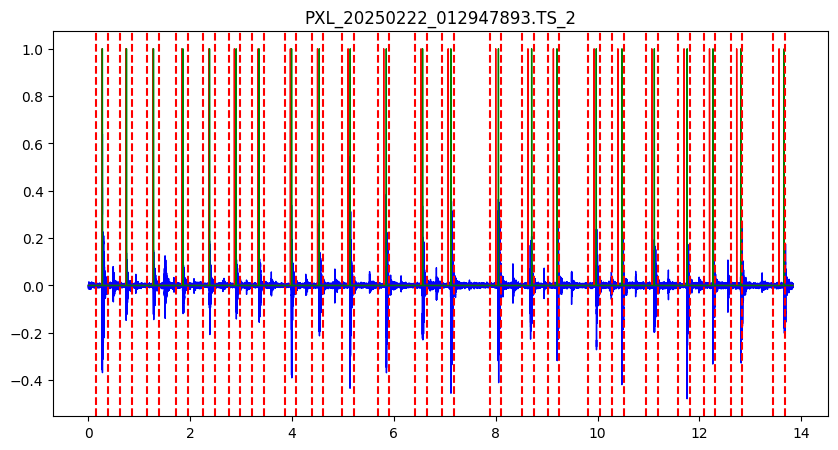

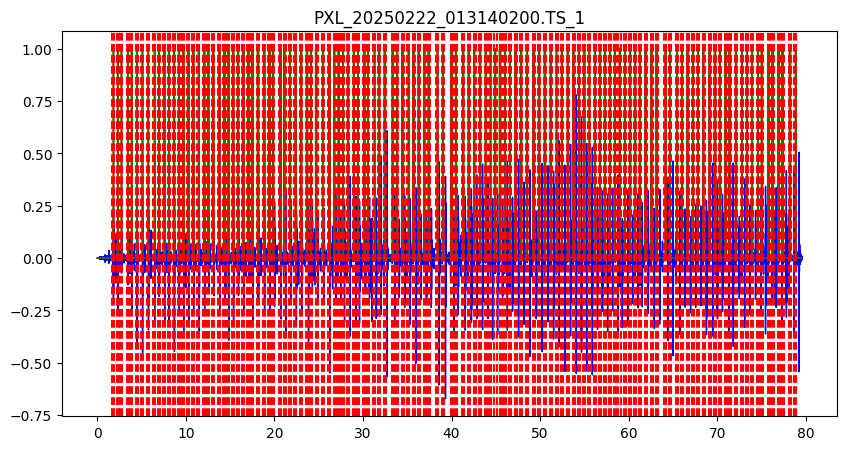

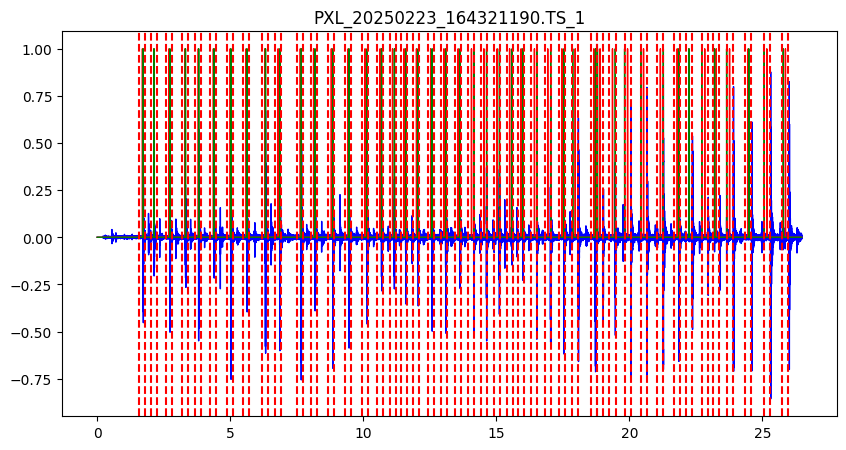

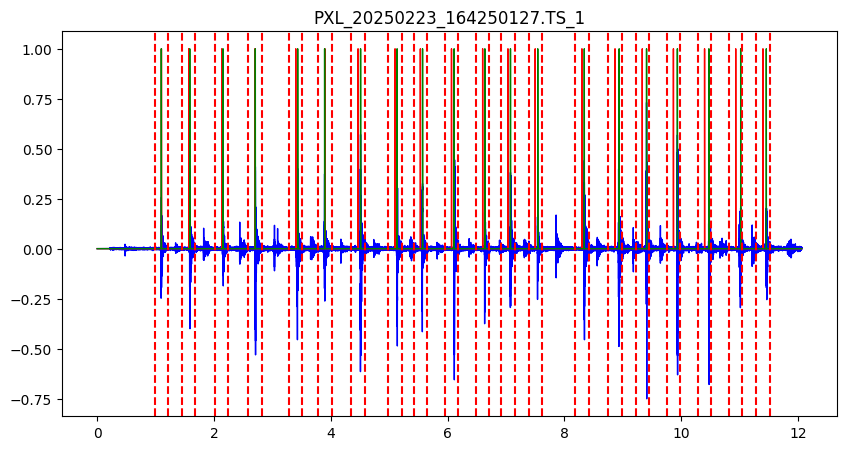

In [ ]:
for base_name in tracker:
        x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
        pd.Series(tracker[base_name]["audio_values"],
                index=x_axis_labels).plot(figsize=(10, 5),
                        lw=1,
                        title=f"Audio File: {base_name}",
                        color='blue',
                        label="Raw Audio")
        pd.Series(tracker[base_name]["labels_full_array"],
                index=x_axis_labels).plot(
                        lw=1,
                        color='r',
                        label="Original Labels")
        pd.Series(tracker[base_name]["labels_corrected"],
                index=x_axis_labels).plot(
                        lw=1,
                        color='green',
                        label="Corrected Labels")
        for i in range(len(tracker[base_name]["labels_full_array"])):
                if tracker[base_name]["labels_full_array"][i] == 1:
                        plt.axvline(x=x_axis_labels[i-LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--', label="Correction Window")
                        plt.axvline(x=x_axis_labels[i+LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--', label="Correction Window")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()

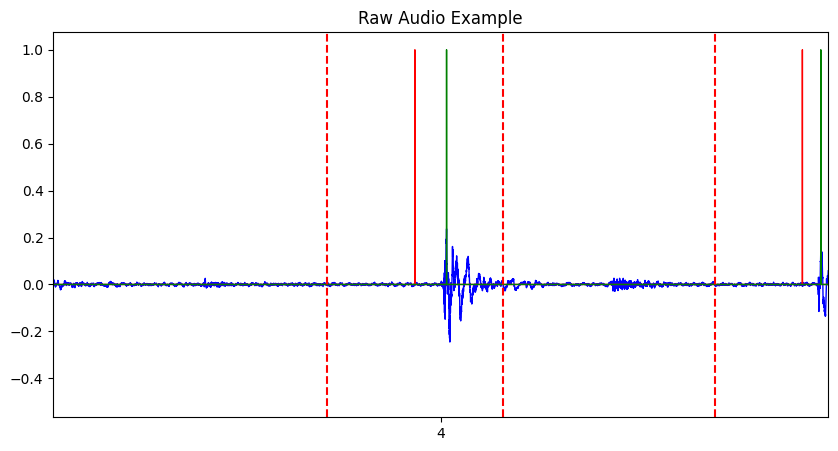

In [ ]:
# Check Label Correction - Zoom In
base_name = 'PXL_20250222_012947893.TS_1'

x_axis_labels = [i / SAMPLE_RATE for i in range(len(tracker[base_name]["audio_values"]))]
pd.Series(tracker[base_name]["audio_values"],
          index=x_axis_labels).plot(figsize=(10, 5),
                  lw=1,
                  title=f"Audio File: {base_name}",
                 color='blue',
                 label='Raw Audio')
pd.Series(tracker[base_name]["labels_full_array"],
          index=x_axis_labels).plot(
                  lw=1,
                 color='r',
                 label='Original Labels')
pd.Series(tracker[base_name]["labels_corrected"],
          index=x_axis_labels).plot(
                  lw=1,
                 color='green',
                 label='Corrected Labels')
for i in range(len(tracker[base_name]["labels_full_array"])):
  if tracker[base_name]["labels_full_array"][i] == 1:
    plt.axvline(x=x_axis_labels[i-LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--', label='Correction Window')
    plt.axvline(x=x_axis_labels[i+LABEL_CORRECTION_SEARCH_WINDOW], color='r', linestyle='--', label='Correction Window')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
# plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlim((3.5, 4.5))
plt.show()

## Pad Data
- Problem
  - The models expect data of consistent dimensions.
  - The raw audio recordings are of different lengths.
  - They will be chopped into smaller segments when fed into the model, but each segment must be of consistent dimensions.
- Solution
  - Determine how many segments the audio file will be chunked into.
    - With window overlap at 50%, we can think of the windows as having two, non-overlapping groups
    - The first group starts at audio start and ends 1/2 window before (audio end + padding)
    - The second group starts at (audio start + 1/2 window) and ends at (audio end + padding)
    - (audio_length + padding) - (0 + 0.5 * WINDOW_LENGTH) % WINDOW_LENGTH = 0
    - So the amount of padding we need is (audio length - 1/2 window) mod window size
  - Pad with zeros until the last segment is the same size as the rest.


In [15]:
def calculate_positive_padding(audio_length, window_length):
    """
    Calculates the padding required to satisfy the given equation, ensuring padding is positive.

    Args:
        audio_length (float): The length of the audio.
        window_length (int): The window length.

    Returns:
        float: The positive padding value.
    """
    modulo_result = (0.5 * window_length) % window_length
    padding = modulo_result - audio_length

    while padding < 0:
        padding += window_length

    return int(padding)

In [ ]:
for base_name in tracker:
  tracker[base_name]["padding_required"] = calculate_positive_padding(
      audio_length=tracker[base_name]["audio_values"].shape[0],
      window_length=WINDOW_SIZE,
  )
  tracker[base_name]["audio_values_padded"] = np.pad(
      tracker[base_name]["audio_values"],
      (0, tracker[base_name]["padding_required"]),
  )
  tracker[base_name]["labels_corrected_padded"] = np.pad(
      tracker[base_name]["labels_corrected"],
      (0, tracker[base_name]["padding_required"]),
  )


python_utils.custom_print(tracker)

{
  'PXL_20250222_012947893.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_1_labels.txt'
    'labels_raw': ['00:00:01;20', '00:00:02;04', '00:00:02;21', '00:00:03;11', '00:00:03;29', '00:00:04;14', '00:00:05;02', '00:00:05;18', '00:00:06;12', '00:00:07;03', ...]
    'audio_values': array([0.        , 0.        , 0.        , ..., 0.00452999, 0.00253988,
       0.00217312], dtype=float32)
    'labels_full_array': array([0., 0., 0., ..., 0., 0., 0.])
    'labels_corrected': array([0., 0., 0., ..., 0., 0., 0.])
    'padding_required': 5984
    'audio_values_padded': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
    'labels_corrected_padded': array([0., 0., 0., ..., 0., 0., 0.])
  }
  'PXL_20250223_164224211.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250223_164224211.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_time

In [17]:
# Check dims
for base_name in tracker:
  print(base_name)
  # print(tracker[base_name]["audio_spectogram_padded"].shape)
  print(tracker[base_name]["audio_values_padded"].shape)
  print(tracker[base_name]["labels_corrected_padded"].shape)
  print("=", tracker[base_name]["audio_values_padded"].shape[0] / WINDOW_SIZE, "windows")
  print()

PXL_20250222_012947893.TS_1
(201788,)
(201788,)
= 30.5 windows

PXL_20250223_164224211.TS_1
(347340,)
(347340,)
= 52.5 windows

PXL_20250222_012947893.TS_2
(307644,)
(307644,)
= 46.5 windows

PXL_20250222_013140200.TS_1
(1756548,)
(1756548,)
= 265.5 windows

PXL_20250223_164321190.TS_1
(585516,)
(585516,)
= 88.5 windows

PXL_20250223_164250127.TS_1
(267948,)
(267948,)
= 40.5 windows



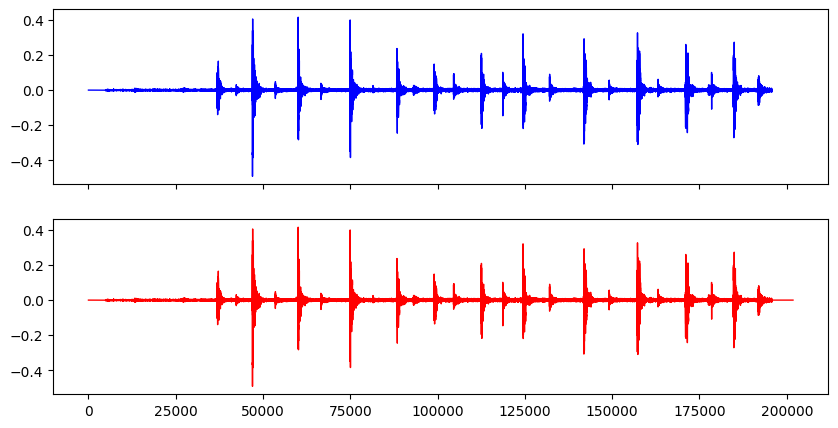

In [18]:
base_name = list(tracker.keys())[0]

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 5), sharex=True)
pd.Series(tracker[base_name]["audio_values"]).plot(
    lw=1,
    color='blue',
    ax=ax[0],
    label="Raw Audio Values"
)
pd.Series(tracker[base_name]["audio_values_padded"]).plot(
    lw=1,
    label='Padded Audio Example',
    color='red',
    ax=ax[1],
)
plt.show()

## Segment Data
- Split data into smaller, uniformly dimensioned, data segments that the model can easily work with.

In [19]:
def get_window_segments(array, window_size):
  """Return window segments overlapping at 50%."""
  return np.array([
      array[i:i+window_size]
      for i in range(0, int(array.shape[0] - 0.5 * window_size), window_size)
  ] + [
      array[i:i+window_size]
      for i in range(int(0.5*window_size), array.shape[0], window_size)
  ])

In [20]:
for base_name in tracker:
  tracker[base_name]["x"] = get_window_segments(
      array=tracker[base_name]["audio_values_padded"],
      window_size=WINDOW_SIZE,
  )
  tracker[base_name]["y_segments"] = get_window_segments(
      array=tracker[base_name]["labels_corrected_padded"],
      window_size=WINDOW_SIZE,
  )


python_utils.custom_print(tracker)

{
  'PXL_20250222_012947893.TS_1': {
    'audio_filename': 'no_ground_hits/audio_files/PXL_20250222_012947893.TS_1_audio.wav'
    'labels_filename': 'no_ground_hits/labels_timestamp/PXL_20250222_012947893.TS_1_labels.txt'
    'labels_raw': ['00:00:01;20', '00:00:02;04', '00:00:02;21', '00:00:03;11', '00:00:03;29', '00:00:04;14', '00:00:05;02', '00:00:05;18', '00:00:06;12', '00:00:07;03', ...]
    'audio_values': array([0.        , 0.        , 0.        , ..., 0.00452999, 0.00253988,
       0.00217312], dtype=float32)
    'labels_full_array': array([0., 0., 0., ..., 0., 0., 0.])
    'labels_corrected': array([0., 0., 0., ..., 0., 0., 0.])
    'padding_required': 5984
    'audio_values_padded': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
    'labels_corrected_padded': array([0., 0., 0., ..., 0., 0., 0.])
    'x': array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         7.3242560e-04,  7.0753385e-04,  7.3038030e-04],
       [ 6.8282022e-04,  6.7373691e-04,  4.2436406e

## Reshape Labels
- Current
    - Labels consist of an array of 1s and 0s of the same length as each audio segment array.
- Target
    - Each audio segment gets a single 1 or 0 label. If there is a juggle in the segment, the label for that segment is 1, otherwize the label is 0.

In [28]:
for base_name in tracker:
  tracker[base_name]["y"] = np.array([
      1 if np.sum(segment) > 0 else 0
      for segment in tracker[base_name]["y_segments"]
  ])

In [29]:
# Check things look correct
for base_name in tracker:
  print(base_name)
  print(tracker[base_name]["x"].shape[0] == tracker[base_name]["y"].shape[0])
  print(tracker[base_name]["y"][:10])

PXL_20250222_012947893.TS_1
True
[0 0 0 0 0 1 0 1 0 1]
PXL_20250223_164224211.TS_1
True
[0 0 0 0 0 0 1 0 1 0]
PXL_20250222_012947893.TS_2
True
[1 0 1 0 1 0 1 1 0 1]
PXL_20250222_013140200.TS_1
True
[0 0 0 0 0 0 1 1 0 1]
PXL_20250223_164321190.TS_1
True
[0 0 0 0 0 1 0 1 0 1]
PXL_20250223_164250127.TS_1
True
[0 0 0 1 0 1 0 1 0 1]


# Save Preprocessed Data

In [ ]:
cols_to_save = [
    "x",
    "y",
]
to_save = dict()
for base_name in tracker:
    to_save[base_name] = {col: tracker[base_name][col] for col in cols_to_save}

with open(os.path.join(PREPROCESSED_DATA_PATH, f"preprocessed_data_{pd.Timestamp.now()}.pkl"), 'wb') as file:
    pickle.dump(to_save, file)